<a href="https://colab.research.google.com/github/BuseOzkanat/BERTileSentimentAnaliz/blob/master/BERTurk_temiz_ipynb_adl%C4%B1_dosyan%C4%B1n_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!ls "/gdrive/My Drive/SDP-buse/"

'BERTurk-accuracy2.ipynb '		    codes	     SDP-buse.ipynb
 BERTurk-accuracy.ipynb			    Data	     shuffle.csv
 Berturk.ipynb				    deneme.ipynb     shuffled.csv
'Berturk.ipynb adlı dosyanın kopyası'	   'kopya Berturk'   turkishBERT.ipynb
'Berturk.ipynb adlı dosyanın kopyası (1)'   newfile.csv


In [ ]:
import os
os.chdir("/gdrive/My Drive/SDP-buse/")

In [ ]:
!pip install trnlp
import numpy as np
import pandas as pd 
import numpy as np
import nltk
import csv
from nltk.corpus import stopwords
from trnlp import TrnlpWord

     |████████████████████████████████| 10.1MB 8.7MB/s 
  Created wheel for trnlp: filename=trnlp-0.2.3a0-cp37-none-any.whl size=10168268 sha256=6d8ed38ad941d928fd3a857b7a6a8d61fa346ceacff50e3a0d0beab66b081b73
  Stored in directory: /root/.cache/pip/wheels/14/ef/af/28ddb21e63f6aaaf7de11f8e93aaaabfb2b809233101040baa
Successfully built trnlp


In [ ]:
import torch
if torch.cuda.is_available():  
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: Tesla K80


In [ ]:
data=pd.read_csv("/gdrive/My Drive/resource/500.2.csv",index_col=[0])

In [ ]:
data.head()

,value,Review
PhraseId,,
314,1,"Telefonu babalar günü için aldım, babamın ilk ..."
36,1,İlk yıkamada etkili kullanmanızı tavsiye ederim
301,1,Ürün gayet güzel giriş seviyesi orta yaşlı bay...
228,1,ürün kaliteli güzel mıknatısı iyi tutuyor ama ...
13,1,fiyat fayda oranına göre çok iyi bir ürün


In [ ]:
data["value"].value_counts()

1    250
0    250
Name: value, dtype: int64

In [ ]:
text = "Review"

In [ ]:
data['Review'] = data['Review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

data['Review'] = data['Review'].str.replace('[^\w\s]','')

data['Review']= data['Review'].str.replace('\d','')

nltk.download('stopwords')
sw = set(stopwords.words('turkish'))
data['Review'] = data['Review'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data=data[["Review","value"]]

In [ ]:
comments = data['Review'].values.tolist()
labels = data['value'].values.tolist()

In [ ]:
cutoff = int(len(data)*0.80)
x_train, x_test = comments[:cutoff], comments[cutoff:]
y_train, y_test = labels[:cutoff], labels[cutoff:]

In [ ]:
!pip install transformers
from transformers import AutoTokenizer
#Load BERT Turkish tokenizer
tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-turkish-cased") 
comments,labels = data['Review'].to_list(), data['value'].to_list() 
import torch

     |████████████████████████████████| 2.1MB 11.2MB/s 
     |████████████████████████████████| 3.3MB 38.4MB/s 
     |████████████████████████████████| 901kB 37.9MB/s 


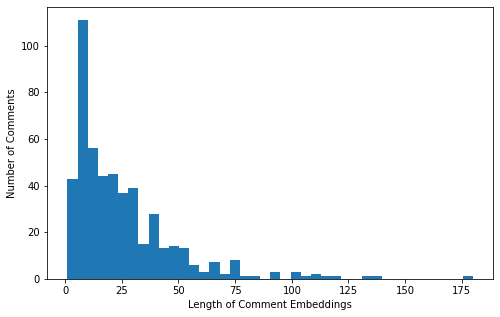

In [ ]:
import matplotlib.pyplot as plt
def plot_sentence_embeddings_length(text_list, tokenizer):
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t), text_list))
    tokenized_texts_len = list(map(lambda t: len(t), tokenized_texts))
    fig, ax = plt.subplots(figsize=(8, 5));
    ax.hist(tokenized_texts_len, bins=40);
    ax.set_xlabel("Length of Comment Embeddings");
    ax.set_ylabel("Number of Comments");
    return
plot_sentence_embeddings_length(comments, tokenizer)

In [ ]:
indices=tokenizer.batch_encode_plus(comments,max_length=64,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)


input_ids=indices["input_ids"]
attention_masks=indices["attention_mask"]

from sklearn.model_selection import train_test_split


train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=42, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=42, test_size=0.2)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels, dtype=torch.long)
validation_labels = torch.tensor(validation_labels, dtype=torch.long)
train_masks = torch.tensor(train_masks, dtype=torch.long)
validation_masks = torch.tensor(validation_masks, dtype=torch.long)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 64

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
from transformers import AutoModelForSequenceClassification, AdamW, AutoConfig
config = AutoConfig.from_pretrained(
        "dbmdz/bert-base-turkish-cased",num_labels=2)

model = AutoModelForSequenceClassification.from_pretrained(
    "dbmdz/bert-base-turkish-cased",config=config)

model.cuda()

Some weights of the model checkpoint at dbmdz/bert-base-turkish-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 6e-6, 
                  eps = 1e-8 )


from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 2

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
  
    elapsed_rounded = int(round((elapsed)))
 
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    
  

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

   
    t0 = time.time()

    total_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

      
        if step % 50 == 0 and not step == 0:
            
            elapsed = format_time(time.time() - t0)
            
            
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

       
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

      
        model.zero_grad()        

     
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
      
        loss = outputs[0]

       
        total_loss += loss.item()

      
        loss.backward()

        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        
        optimizer.step()

      
        scheduler.step()

    
    avg_train_loss = total_loss / len(train_dataloader)            
    
    
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(format_time(time.time() - t0)))
      
print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...

  Average training loss: 0.70
  Training epoch took: 0:00:08

======== Epoch 2 / 2 ========
Training...

  Average training loss: 0.69
  Training epoch took: 0:00:07

Training complete!


3) BERTurk Model Performance on Test Set

In [ ]:
comments1 = data['Review'].values.tolist()
labels1 = data['value'].values.tolist()

cutoff = int(len(data)*0.80)
x_train, x_test = comments1[:cutoff], comments1[cutoff:]
y_train, y_test = labels1[:cutoff], labels1[cutoff:]


indices1=tokenizer.batch_encode_plus(comments1,max_length=128,add_special_tokens=True, return_attention_mask=True,pad_to_max_length=True,truncation=True)
input_ids1=indices1["input_ids"]
attention_masks1=indices1["attention_mask"]

prediction_inputs1= torch.tensor(input_ids1)
prediction_masks1 = torch.tensor(attention_masks1)
prediction_labels1 = torch.tensor(labels1)


prediction_data1 = TensorDataset(prediction_inputs1, prediction_masks1, prediction_labels1)
prediction_sampler1 = SequentialSampler(prediction_data1)
prediction_dataloader1 = DataLoader(prediction_data1, sampler=prediction_sampler1, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs1)))

model.eval()

predictions , true_labels = [], []

for batch in prediction_dataloader1:

  batch = tuple(t.to(device) for t in batch)
  

  b_input_ids1, b_input_mask1, b_labels1 = batch
 
  with torch.no_grad():
     
      outputs1 = model(b_input_ids1, token_type_ids=None, 
                      attention_mask=b_input_mask1)

  logits1 = outputs1[0]

  logits1 = logits1.detach().cpu().numpy()
  label_ids1 = b_labels1.to('cpu').numpy()
  
  predictions.append(logits1)
  true_labels.append(label_ids1)

print('    DONE.')

Predicting labels for 500 test sentences...
    DONE.


In [ ]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy of BERT is:",accuracy_score(flat_true_labels, flat_predictions))

Accuracy of BERT is: 0.592


In [ ]:
print(batch_size)

64


In [ ]:
print(epochs)

2


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(flat_true_labels, flat_predictions))

              precision    recall  f1-score   support

           0       0.58      0.66      0.62       250
           1       0.61      0.52      0.56       250

    accuracy                           0.59       500
   macro avg       0.59      0.59      0.59       500
weighted avg       0.59      0.59      0.59       500

